## LSTM Ethereum Classic Autoencoder
This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [1]:
# import libraries
import os
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
from google.cloud import bigquery
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline

# model parameters
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [2]:
# set random seed
seed(42)
tf.random.set_seed(42)

# Data loading and pre-processing
Load the data between 06/01/2015 to 06/

In [3]:
# Load the ethereum classic data
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/git/machine-learning-api-328501-6ba46c774829.json"
client = bigquery.Client()
ethereum_classic_dataset_ref = client.dataset('crypto_ethereum_classic', project='bigquery-public-data')

query = """
SELECT timestamp, number, difficulty, size, gas_used, transaction_count
FROM
  `bigquery-public-data.crypto_ethereum_classic.blocks` AS blocks
WHERE timestamp BETWEEN "2016-01-01 00:00:00+00:00" AND "2016-12-30 23:59:59+00:00"
ORDER BY timestamp
"""

query_job = client.query (query)
iterator = query_job.result()
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

df

,timestamp,number,difficulty,size,gas_used,transaction_count
0,2016-01-01 00:00:04+00:00,778483,8470917144249,799,63447,2
1,2016-01-01 00:00:43+00:00,778484,8466780954270,1581,100994,3
2,2016-01-01 00:00:56+00:00,778485,8462646783915,541,0,0
3,2016-01-01 00:01:00+00:00,778486,8466778935696,543,0,0
4,2016-01-01 00:01:14+00:00,778487,8462644766326,658,21000,1
...,...,...,...,...,...,...
2136177,2016-12-30 23:58:57+00:00,2914660,14620548588571,645,21000,1
2136178,2016-12-30 23:59:02+00:00,2914661,14627821746039,655,21000,1
2136179,2016-12-30 23:59:07+00:00,2914662,14635098454853,656,21000,1
2136180,2016-12-30 23:59:35+00:00,2914663,14628086628414,865,72376,3


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [4]:
# transform data file index to datetime and sort in chronological order
#df.index = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
#df = df.sort_index()
df.to_csv('Ethereum_Classic_data.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (2136182, 6)


,timestamp,number,difficulty,size,gas_used,transaction_count
0,2016-01-01 00:00:04+00:00,778483,8470917144249,799,63447,2
1,2016-01-01 00:00:43+00:00,778484,8466780954270,1581,100994,3
2,2016-01-01 00:00:56+00:00,778485,8462646783915,541,0,0
3,2016-01-01 00:01:00+00:00,778486,8466778935696,543,0,0
4,2016-01-01 00:01:14+00:00,778487,8462644766326,658,21000,1


In [5]:
def get_date( input_date ):
    return str(df.timestamp[0]).split(" ")[0]

# get the dates
initial = get_date(df.timestamp[0])
pool_data = { 'date': [] }
dates = []
for index, row in df.iterrows():
    date = get_date( row['timestamp'] )
    # add the entry
    if date not in pool_data.keys():
        dates.append( date )
        pool_data[ date ] = {   'size': [],
                                'gas': [],
                                'difficulty': [],
                                'transactions': []}
    # add the data
    pool_data[ date ][ 'size' ].append( row['size'] )
    pool_data[ date ][ 'gas' ].append( row['gas_used'] )
    pool_data[ date ][ 'difficulty' ].append( row['difficulty'] )
    pool_data[ date ][ 'transactions' ].append( row['transaction_count'] )


In [ ]:
# initial lists for daily values
block_size = []
provided_gas = []
block_difficulty = []
transaction = []
total_gas = []
total_transactions = []

# 

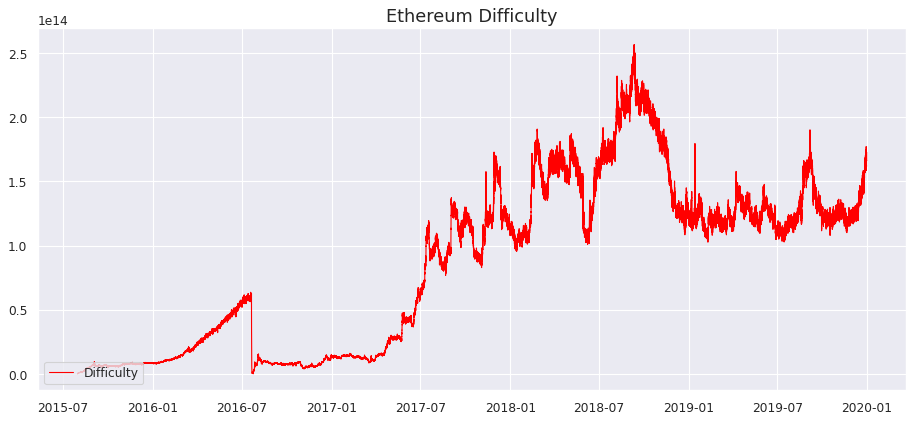

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df['timestamp'], df['difficulty'], label='Difficulty', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Ethereum Difficulty', fontsize=16)
plt.show()

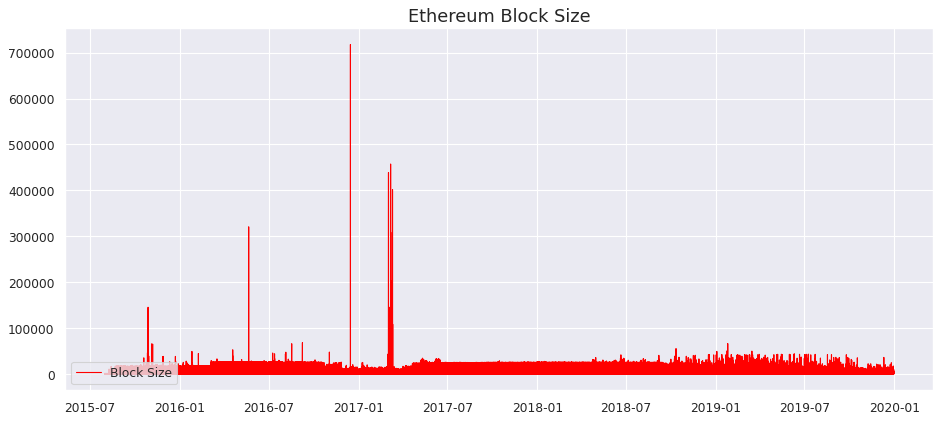

In [17]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df['timestamp'], df['size'], label='Block Size', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Ethereum Block Size', fontsize=16)
plt.show()

KeyError: 'datetime'

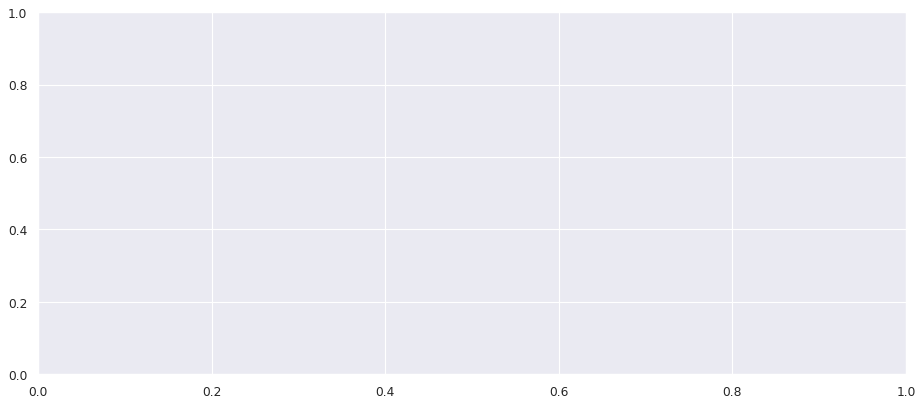

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df['timestamp'], df['gas_used'], label='Size', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Ethereum Gas Used', fontsize=16)
plt.show()

KeyboardInterrupt: 

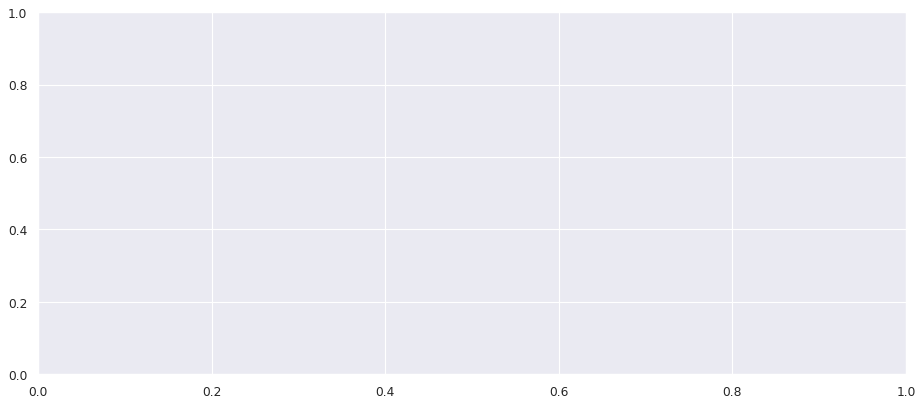

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df['timestamp'], df['transaction_count'], label='Transaction Count', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Ethereum Transaction Count', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [ ]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
df_fft = np.fft.fft(df)


TypeError: must be real number, not Timestamp

In [ ]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

In [ ]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

In [ ]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [ ]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")